## Importing Libraries

In [113]:
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

## Importing Data

In [114]:
furniture = pd.read_csv("Super_Store.csv",sep=",", encoding='cp1252')

## Cleaning Data

In [115]:
# furniture.head()
# furniture.describe()
# furniture.info()

In [116]:
furniture.isna().sum().any()

False

In [117]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

In [118]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture = furniture[['Order Date', 'Sales']].sort_values('Order Date')

In [119]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.set_index('Order Date', inplace=True)
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


## Visualizing Data

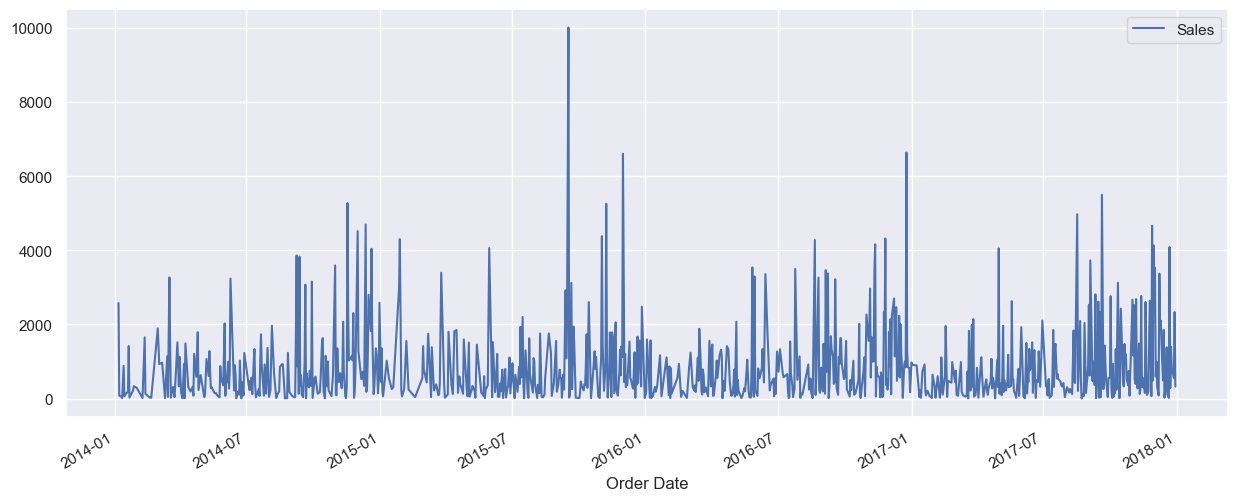

In [120]:
furniture.plot(figsize=(15, 6))
plt.show()

## Sampling (converting data from daily to monthly)

In [121]:
y = furniture['Sales'].resample('MS').mean()  #MS = month start

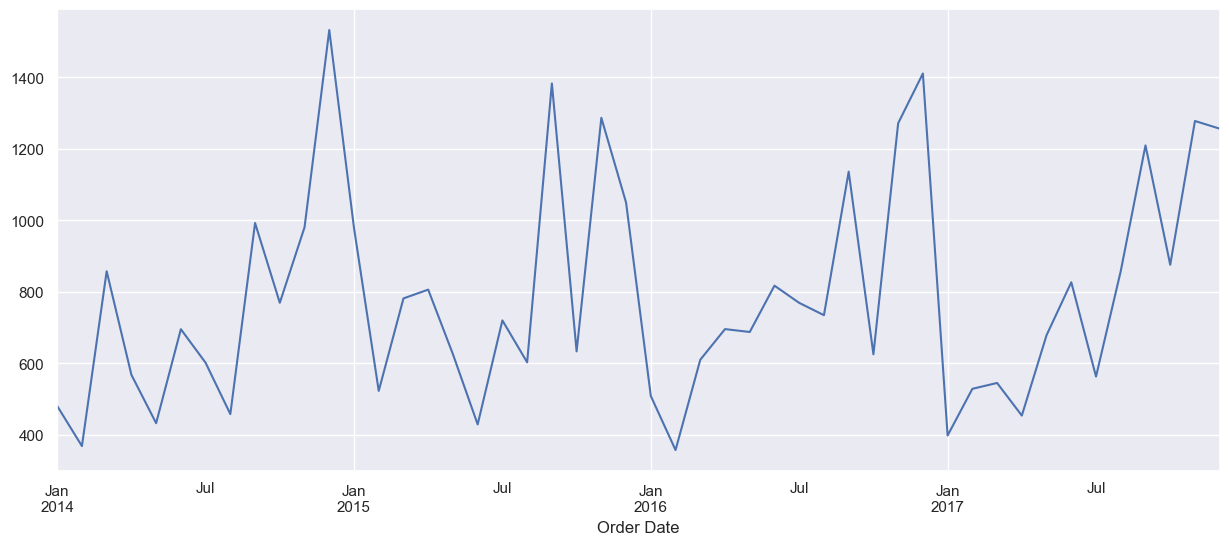

In [122]:
y.plot(figsize=(15, 6))
plt.show()

## Decomposition

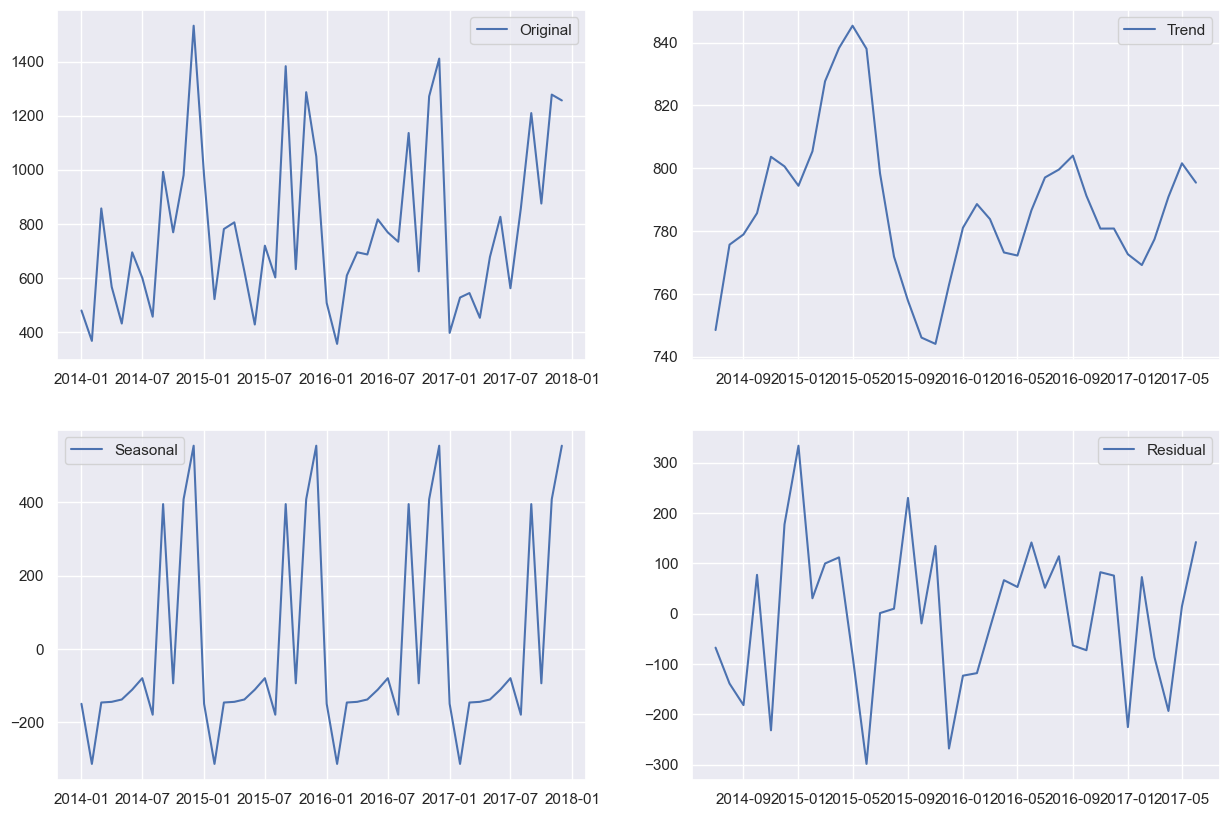

In [123]:
decomposition = seasonal_decompose(y)
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(y, label = 'Original')
ax[0,0].legend(loc = 'best')

trend = decomposition.trend
ax[0,1].plot(trend, label = 'Trend')
ax[0,1].legend(loc = 'best')

seasonal = decomposition.seasonal
ax[1,0].plot(seasonal, label = 'Seasonal')
ax[1,0].legend(loc = 'best')

residual = decomposition.resid
ax[1,1].plot(residual, label = 'Residual')
ax[1,1].legend(loc='best')
plt.show()

## Checking stationarity

##### Using Augmented Dickey-Fuller(ADF) test to check if our time series is stationary or not

Null Hypothesis: The series has a unit root - not stationary <br>
Alternate Hypothesis: The series has no unit - stationary

In [124]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
1%: -3.6209175221605827
5%: -2.9435394610388332
10%: -2.6104002410518627


We can see that our statistic value of -5.191 is less than the value of -3.621 at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1%.
Rejecting the null hypothesis means that the process has no unit root,it suggests the time series does not have a unit root, meaning it is stationary.

## Time Series Forecasting

In [125]:
# p,d,q = seasonality,trend,noise
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Finding Best Parameters

In [126]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f"Best SARIMAX{best_pdq}x{best_seasonal_pdq} model - AIC:{best_aic}")

Best SARIMAX(0, 1, 1)x(0, 1, 1, 12) model - AIC:279.58062333707863


## Fitting the ARIMA model

In [127]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=best_pdq,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   3991.744     -0.000      1.000   -7824.675    7822.675
ma.S.L12      -3.2469      1.665     -1.950      0.051      -6.510       0.016
sigma2      2368.6840   9.46e+06      0.000      1.000   -1.85e+07    1.85e+07


## Forecast Validation

comparing predicted sales to real sales of the time series to understand the accuracy of our forecasts

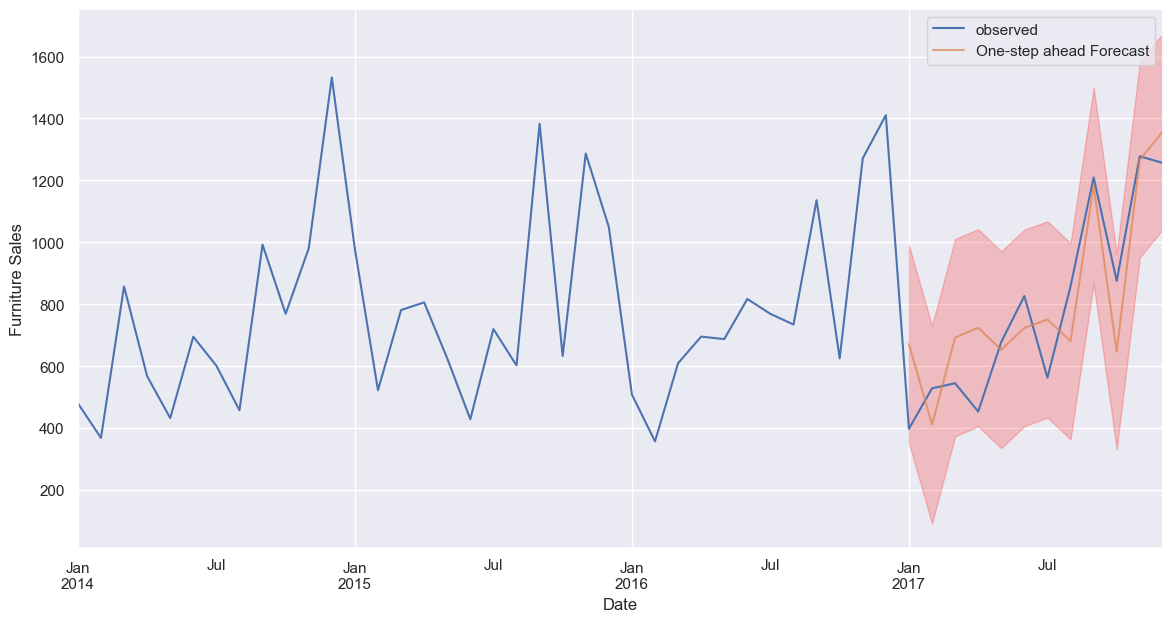

In [128]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Calculating MSE and RMSE

In [129]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 27090.48
The Root Mean Squared Error of our forecasts is 164.59


## Forecast Visualisation

            lower Sales  upper Sales
2018-01-01   169.635942   800.791646
2018-02-01   184.857026   816.402287
2018-03-01   280.604655   912.149187
2018-04-01   229.753789   861.298321
2018-05-01   368.004669   999.549200
2018-06-01   491.916278  1123.460810
2018-07-01   316.102249   947.646781
2018-08-01   501.564142  1133.108673
2018-09-01   897.528945  1529.073477
2018-10-01   500.578065  1132.122597
2018-11-01   967.036473  1598.581005
2018-12-01   980.347239  1611.891796
2019-01-01   104.211103   885.322957


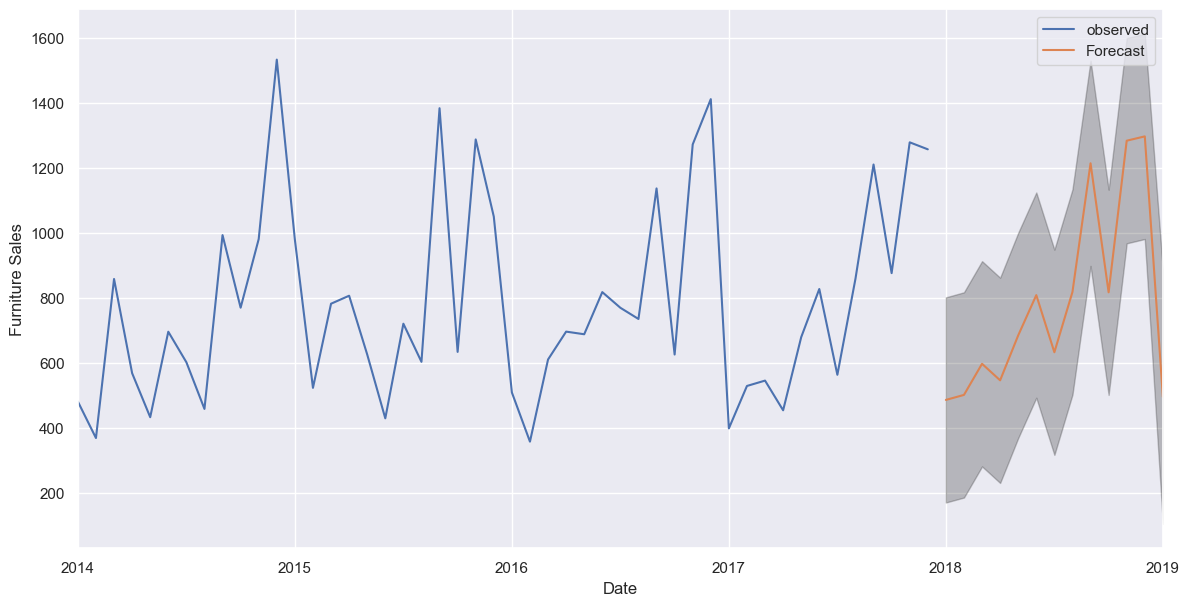

In [130]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()